## LGBM regression on IE dataset
### Using functional group features & cross validation 

**Created on 29th August, 2022; modified on 7th September; remodified on 25th February, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
# from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna ## hyperparameter optimization
import lightgbm as lgb
from lightgbm import LGBMRegressor
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/oxidative-stability_1.1/lgbm_trials/stratified-split-2-cv
total 19856
-rw-------@ 1 riteshk  staff  3960002 Feb 25 03:56 rand_train_fgrp_feat.csv
-rw-------@ 1 riteshk  staff   495572 Feb 25 03:57 val_train_fgrp_feat.csv
-rw-------@ 1 riteshk  staff   497131 Feb 25 03:57 test_train_fgrp_feat.csv
-rw-r--r--  1 riteshk  staff  3905466 Feb 25 04:14 train_qsar_stratII_oxstab.csv
-rw-r--r--  1 riteshk  staff   490277 Feb 25 04:14 val_qsar_stratII_oxstab.csv
-rw-r--r--  1 riteshk  staff   489098 Feb 25 04:14 test_qsar_stratII_oxstab.csv
-rw-------@ 1 riteshk  staff    86288 Feb 25 04:14 split_dataset_strat2_oxstab_sl.ipynb
-rw-------@ 1 riteshk  staff   228986 Feb 25 04:15 oxstab_lgbm_strat2.ipynb


Read the train, validation, and test sets

In [2]:
train_df = pd.read_csv('train_qsar_stratII_oxstab.csv')
val_df = pd.read_csv('val_qsar_stratII_oxstab.csv')
test_df = pd.read_csv('test_qsar_stratII_oxstab.csv')
train_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE,IE_binned
0,Cn1ccc(c1C(=N)O)OC,0,0,0,0,0,0,0,0,0,...,41.4225,58.24,0.285714,-1.45,64.538491,60,0.231350,-0.494299,4.343441,4
1,C=CC1=CN(C)C=C[C]1[C]1C=CN(C)C=C1C,0,0,0,0,0,0,0,0,0,...,72.3290,6.48,0.200000,-1.70,103.908431,88,0.044919,-0.357572,1.838448,1
2,COCCOCCOCCOC1=CS/C(=C\2/SC=C(N)S2)/S1,0,0,0,0,0,0,0,0,0,...,97.2094,62.94,0.538462,0.10,147.324597,124,0.164836,-0.484027,3.163768,3
3,C=C,0,0,0,0,0,0,0,0,0,...,11.2540,0.00,0.000000,-0.26,14.414590,12,-0.106311,-0.106311,6.126331,6
4,CC(C)(C)c1cc(cs1)OCCOC,0,0,0,0,0,0,0,0,0,...,60.3900,18.46,0.636364,-0.54,89.853452,80,0.129899,-0.490309,4.166354,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,c1(cc2c(cc1)nc(cn2)C)NC,0,0,0,0,0,0,0,0,0,...,53.8217,37.81,0.200000,-1.64,76.832110,66,0.090707,-0.388057,3.968161,3
14501,CN(C)C1=CCC=C(OC)O1,0,0,0,0,0,0,0,0,0,...,42.5640,21.70,0.500000,-1.12,66.895733,62,0.281253,-0.468662,3.617945,3
14502,COC1=C(N(=O)=O)OC=CC1,0,0,0,0,0,0,0,0,0,...,35.8714,61.60,0.333333,-1.52,63.058991,60,0.470859,-0.491109,4.684524,4
14503,C1CCC(SC1)(N(=O)=O)N(=O)=O,0,0,0,0,0,0,0,0,0,...,43.0288,86.28,1.000000,-0.85,72.622250,68,0.505619,-0.257553,5.671555,5


In [3]:
df = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df.reset_index(drop=True, inplace=True)
zero_columns = list(df.columns[(df == 0).all()]) ## oxstab dataset has columns with only zero entries so have to remove them, otherwise causes problem with Sobol analysis
zero_columns

['fr_func_grp_6_solv',
 'fr_func_grp_16_solv',
 'fr_func_grp_22_solv',
 'fr_func_grp_24_solv',
 'fr_func_grp_26_solv',
 'fr_func_grp_28_solv',
 'fr_func_grp_33_solv',
 'fr_func_grp_38_solv',
 'fr_func_grp_41_solv']

In [4]:
df.drop(columns=zero_columns, inplace=True)
train_df.drop(columns=zero_columns, inplace=True)
val_df.drop(columns=zero_columns, inplace=True)
test_df.drop(columns=zero_columns, inplace=True)
df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [5]:
X_train = train_df.iloc[:,1:-2]
y_train = train_df.iloc[:,-2]
X_val = val_df.iloc[:,1:-2]
y_val = val_df.iloc[:,-2]
X_test = test_df.iloc[:,1:-2]
y_test = test_df.iloc[:,-2]

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)
X_train_.shape

(14505, 47)

In [8]:
# def objective(trial):
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)

#     param = {
#         "objective": "regression",
#         "metric": "root_mean_squared_error",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 100),
#         "num_iterations": trial.suggest_int("num_iterations", 50, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "max_bin": trial.suggest_int("max_bin", 2, 50),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
#         "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
#     }

#     gbm = LGBMRegressor(**param)
#     cv = cross_val_score(gbm, X_train_, y_train, cv=kf, scoring='neg_root_mean_squared_error')
#     return -cv.mean()

In [9]:
# fname = 'best-paramters_lgbr_random.txt'
# f = open(fname, 'w')
# f1 = open('best-paramters_lgbr_all.txt', 'a')
# if __name__ == "__main__":
#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=200)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     f.write("  Value: {}\n".format(trial.value))
#     f1.write("  Value: {}\n".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value)) 
#         f.write("    {}: {}\n".format(key, value))
#         f1.write("    {}: {}\n".format(key, value))

# f.write("\n")
# f1.write("\n")
# f.close()
# f1.close()

[I 2024-02-14 11:56:38,450] A new study created in memory with name: no-name-a94f0768-cfb4-40d6-9486-e6beff84b716
[I 2024-02-14 11:56:38,987] Trial 0 finished with value: 0.6001481381528382 and parameters: {'lambda_l1': 3.4467854578742806e-06, 'lambda_l2': 5.7549366182366186e-08, 'num_leaves': 89, 'num_iterations': 132, 'max_depth': 9, 'max_bin': 7, 'feature_fraction': 0.8067129371227151, 'bagging_fraction': 0.9124216607551318, 'bagging_freq': 1, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.9208233364444045, 'learning_rate': 0.830075755337337, 'min_sum_hessian_in_leaf': 0.10883074417761751}. Best is trial 0 with value: 0.6001481381528382.
[I 2024-02-14 11:56:41,024] Trial 1 finished with value: 0.6445171177238255 and parameters: {'lambda_l1': 1.0869125068411486e-06, 'lambda_l2': 0.002662106389632919, 'num_leaves': 5, 'num_iterations': 433, 'max_depth': 5, 'max_bin': 36, 'feature_fraction': 0.8434962344737861, 'bagging_fraction': 0.5020501049973511, 'bagging_freq': 10, 'min_data_in_le

Number of finished trials: 200
Best trial:
  Value: 0.3765984512506253
  Params: 
    lambda_l1: 6.615391132414117e-07
    lambda_l2: 3.1907163628802457e-07
    num_leaves: 49
    num_iterations: 500
    max_depth: 6
    max_bin: 43
    feature_fraction: 0.9957769701688443
    bagging_fraction: 0.5832158471965193
    bagging_freq: 1
    min_data_in_leaf: 29
    min_gain_to_split: 0.13206618700186268
    learning_rate: 0.1970884217888203
    min_sum_hessian_in_leaf: 0.3281115932823233


In [6]:
def read_param():
    fname = '../random-split/best-paramters_lgbr_random.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [7]:
## hyoerparameters used from random split
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param()
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

6.615391132414117e-07 3.1907163628802457e-07 49 500 6 43 0.9957769701688443 0.5832158471965193 1 29 0.13206618700186268 0.1970884217888203 0.3281115932823233


In [8]:
## optimize over random states of KFold
rmse_cv_array = []
for i in range(0,100):
    print(f"Step {i}")
    # Initialize KFold cross-validation
    skf = KFold(n_splits=5, shuffle=True, random_state=i)
    stratify_labels = train_df['IE_binned']
    lgbm = LGBMRegressor(**params, verbose=-1)
    # plsr = PLSRegression(n_components=ncomp, scale=True) ## don't use scale=True

    fold = 1
    # Loop over each fold
    rmse_val = []; rmse_train = []
    for train_index, val_index in skf.split(X_train_, stratify_labels):
        # print("Fold {}".format(fold))
        # Split the data
        X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training data
        lgbm.fit(X_train_fold, y_train_fold)

        y_pred_val_fold = lgbm.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
        # print(f"Train set CV, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_train.append(rmse)

        ## predict on validation test
        y_pred_val = lgbm.predict(X_val_)
        r2 = r2_score(y_val, y_pred_val); rmse = np.sqrt(mean_squared_error(y_val, y_pred_val)); mae = mean_absolute_error(y_val, y_pred_val)
        # print(f"Validation set, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_val.append(rmse)

        fold += 1
    # print(f"RMSE train: {np.mean(rmse_train)} & RMSE val: {np.mean(rmse_val)}")
    rmse_cv_array.append(np.mean(rmse_train))

ind = min(range(len(rmse_cv_array)), key=rmse_cv_array.__getitem__)
print(rmse_cv_array[ind])

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
0.3706683524507053


In [9]:
## use the best random state to train the model
skf = KFold(n_splits=5, shuffle=True, random_state=ind)
stratify_labels = train_df['IE_binned']

lgbm = LGBMRegressor(**params, verbose=-1)

fold = 1
# Loop over each fold
pred_train_array = []; pred_val_array = []; pred_test_array = []
for train_index, val_index in skf.split(X_train_, stratify_labels):
    X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model on the training data
    lgbm.fit(X_train_fold, y_train_fold)

    # Store the model
    # models.append(plsr)
    y_pred_val_fold = lgbm.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
    
    y_pred_train = lgbm.predict(X_train_)
    pred_train_array.append(y_pred_train)

    ## predict on validation test
    y_pred_val = lgbm.predict(X_val_)
    pred_val_array.append(y_pred_val)

    # ## predict on test set
    y_pred_test = lgbm.predict(X_test_)
    pred_test_array.append(y_pred_test)

    ## save plsr model to pickle
    filename = f'./lgbm_oxstab_strat2_fold_{fold}.sav'
    pickle.dump(lgbm, open(filename, 'wb'))
    fold += 1

## calculate the average of the predictions on train, val and test
y_pred_train_avg = np.mean(pred_train_array, axis=0); y_pred_val_avg = np.mean(pred_val_array, axis=0); y_pred_test_avg = np.mean(pred_test_array, axis=0)
r2_train = r2_score(y_train, y_pred_train_avg); rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_avg)); mae_train = mean_absolute_error(y_train, y_pred_train_avg)
r2_val = r2_score(y_val, y_pred_val_avg); rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_avg)); mae_val = mean_absolute_error(y_val, y_pred_val_avg)
r2_test = r2_score(y_test, y_pred_test_avg); rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg)
print(f"RMSE train: {rmse_train} & RMSE val: {rmse_val} & RMSE test: {rmse_test}")
print(f"R2 train: {r2_train} & R2 val: {r2_val} & R2 test: {r2_test}")
print(f"MAE train: {mae_train} & MAE val: {mae_val} & MAE test: {mae_test}")

RMSE train: 0.2615318196649524 & RMSE val: 0.37522103590047323 & RMSE test: 0.3563867643913394
R2 train: 0.9505169553549448 & R2 val: 0.8974441790912474 & R2 test: 0.9070046845399985
MAE train: 0.1786640533021659 & MAE val: 0.24472952913649174 & MAE test: 0.23030370432536387


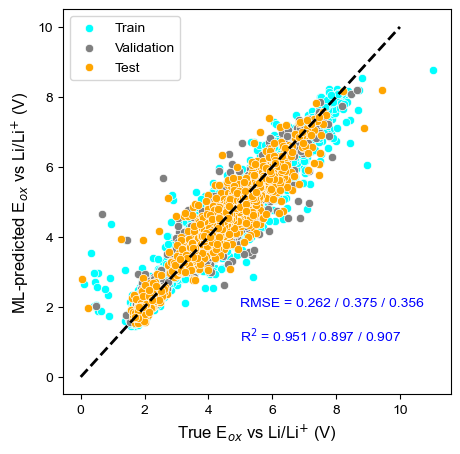

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
xl = np.arange(0,11,1)
yl = np.arange(0,11,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='black')  

# plt.tick_params(axis='both', direction='in')
plt.xlabel('True E$_{ox}$ vs Li/Li$^{+}$ (V)',fontsize=12)
plt.ylabel('ML-predicted E$_{ox}$ vs Li/Li$^{+}$ (V)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
# plt.grid()
plt.text(5, 2, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train, rmse_val, rmse_test), color='blue')
plt.text(5, 1, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(r2_train, r2_val, r2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

**Predict on OOD**

In [18]:
df_ood = pd.read_csv('oxstab_ood_fgrp_feat.csv')
df_ood

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,FC(F)(F)COCCOCC(F)(F)F,0,0,0,0,0,0,0,0,0,...,2.1442,33.7480,18.46,1.0,-0.500000,75.784264,86,0.411279,-0.369644,6.259262
1,FC(F)(F)C(F)(F)COCCOCC(F)(F)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,3.4148,43.6420,18.46,1.0,-0.780000,105.176290,122,0.455266,-0.372419,6.277077
2,CCOCCOCCOCC,0,0,0,0,0,0,0,0,0,...,1.0760,43.8050,27.69,1.0,-0.120000,68.634482,68,0.070112,-0.379347,5.587656
3,FC(F)(F)COCCOCCOCC(F)(F)F,0,0,0,0,0,0,0,0,0,...,2.1608,44.5670,27.69,1.0,-0.540000,93.627694,104,0.411279,-0.376668,6.003231
4,FC(F)(F)C(F)(F)COCCOCCOCC(F)(F)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,3.4314,54.4610,27.69,1.0,-0.820000,123.019720,140,0.455266,-0.376668,6.018283
5,CCOCCOCCOCCOCC,0,0,0,0,0,0,0,0,0,...,1.0926,54.6240,36.92,1.0,-0.160000,86.477911,86,0.070114,-0.379347,5.939028
6,FC(F)(F)COCCOCCOCCOCC(F)(F)F,0,0,0,0,0,0,0,0,0,...,2.1774,55.3860,36.92,1.0,-0.580000,111.471123,122,0.411279,-0.376668,5.757092
7,FC(F)(F)C(F)(F)COCCOCCOCCOCC(F)(F)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,3.4480,65.2800,36.92,1.0,-0.860000,140.863149,158,0.455266,-0.376668,5.759758
8,CCOCCOCCOCCOCCOCC,0,0,0,0,0,0,0,0,0,...,1.1092,65.4430,46.15,1.0,-0.200000,104.321340,104,0.070114,-0.379347,5.916364
9,FC(F)(F)COCCOCCOCCOCCOCC(F)(F)F,0,0,0,0,0,0,0,0,0,...,2.1940,66.2050,46.15,1.0,-0.620000,129.314553,140,0.411279,-0.376668,5.722913


In [19]:
df_ood.drop(columns=zero_columns, inplace=True)
df_ood.reset_index(drop=True, inplace=True)

X_ood = df_ood.iloc[:,1:-1]
y_ood = df_ood.iloc[:,-1]

X_ood.shape

(40, 47)

In [20]:
X_ood_std  = std_scale.transform(X_ood)
X_ood_std = pd.DataFrame(X_ood_std, columns=X_ood.columns)
X_ood_ = np.array(X_ood_std)

In [21]:
pred_ood_array = []
for i in range(1,6):
    filename = f'./lgbm_oxstab_strat2_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred_ood = loaded_model.predict(X_ood_)
    pred_ood_array.append(y_pred_ood)

In [22]:
y_pred_ood_avg = np.mean(pred_ood_array, axis=0)
r2_ood = r2_score(y_ood, y_pred_ood_avg); rmse_ood = np.sqrt(mean_squared_error(y_ood, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_ood, y_pred_ood_avg)
print(f"RMSE ood: {rmse_ood} & MAE ood: {mae_ood}")

RMSE ood: 0.6774509623172714 & MAE ood: 0.571346996667206
